# Diagnosis Benchmarking Example

This notebook provides a comprehensive workflow for benchmarking machine learning models in the context of Prognostics and Health Management (PHM) using multiple datasets with the package `phmd`. The focus is on fault detection tasks. 

The following functions are utility functions used in the benchmarking loop:

In [2]:
from phmd import datasets
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def window_split(X, unit_id, signal_cols, target_col, subsignal_length=1000, signal_max_length=20000):
    """
    Splits time-series data into fixed-length windows for training machine learning models.
    
    This function processes time-series data, splitting it into smaller, fixed-length segments (windows).
    It ensures that each segment corresponds to a specific unit identified by the `unit_id` column
    and aligns the target variable for each segment to the last value in the window. 
    
    Parameters:
    -----------
    X : pandas.DataFrame
        The input dataset containing the time-series data.
        Must include columns specified by `unit_id`, `signal_cols`, and `target_col`.
    
    unit_id : str
        The name of the column in `X` used to identify individual units in the dataset.
    
    signal_cols : list of str
        A list of column names in `X` representing the signal data (features) for each unit.
    
    target_col : str
        The name of the column in `X` representing the target variable to predict.
    
    subsignal_length : int, optional, default=1000
        The length of each window (number of time-steps) to extract from the signal.
    
    signal_max_length : int, optional, default=20000
        The maximum number of time-steps to consider per unit.
        Excess data is truncated from the beginning to fit within this limit.
    
    Returns:
    --------
    X : numpy.ndarray
        A 3D array of shape `(num_windows, subsignal_length, num_features)`, where:
            - `num_windows` is the total number of extracted windows across all units.
            - `subsignal_length` is the fixed length of each window.
            - `num_features` is the number of signal features.
    
    Y : numpy.ndarray
        A 1D array of shape `(num_windows,)` containing the target variable values
        for each window, corresponding to the last time-step in the window.
    
    Example:
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({
    ...     'unit_id': [1, 1, 1, 2, 2, 2],
    ...     'signal1': [0.1, 0.2, 0.3, 0.5, 0.6, 0.7],
    ...     'signal2': [0.4, 0.5, 0.6, 0.8, 0.9, 1.0],
    ...     'target': [10, 20, 30, 40, 50, 60]
    ... })
    >>> X, Y = window_split(df, 'unit_id', ['signal1', 'signal2'], 'target', subsignal_length=2, signal_max_length=4)
    >>> print(X.shape)
    (2, 2, 2)
    >>> print(Y)
    [20. 50.]
    """
        
    units_array = X[unit_id].values
    signal_array = X[signal_cols].values
    targets = X[target_col].values
    N = signal_max_length // subsignal_length

    num_units = X[unit_id].drop_duplicates().shape[0]
    unique_units = X[unit_id].drop_duplicates().values
    X = np.zeros((N * num_units, subsignal_length, len(signal_cols)))
    Y = np.zeros((N * num_units,))
    NN = 0
    for i, unit in enumerate(unique_units):
        mask = np.all(units_array == unit, axis=1)
        signal = signal_array[mask]
        sml = (signal.shape[0] // subsignal_length) * subsignal_length
        n = min(sml // subsignal_length, N)
        sml = subsignal_length * n
        signal = signal[-sml:]
        signal = signal.reshape((n, subsignal_length, len(signal_cols)))
        signal_target = targets[mask][-sml:]
        signal_target = signal_target.reshape((n, subsignal_length))
        X[NN:NN + n] = signal
        Y[NN:NN + n] = signal_target[:, -1]
        NN += n

    X = X[:NN]

    return X, Y


def create_conv_1d_network(input_shape, num_classes):
    """
    This function defines a 1D CNN architecture suitable for RUL tasks.
    The model consists of multiple convolutional layers, followed by 
    max-pooling layers for feature extraction,  and dense layers for prediction.
    
    Parameters:
    -----------
    input_shape : tuple
        The shape of the input data (timesteps, features). This defines the dimensions 
        of the input layer.

    num_classes : int
        Number of classes of the target variable        
    
    Returns:
    --------
    tf.keras.Model
        A compiled Keras Model with the defined architecture.
    """
    # Define the input layer
    input = tf.keras.layers.Input(input_shape)

    # Initialize the input for stacking
    x = input

    # Add 4 blocks of convolutional and pooling layers
    for i in range(4):
        # Each block contains three Conv1D layers with 64 filters and a kernel size of 3
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        # Add a MaxPooling1D layer to downsample the feature maps
        x = tf.keras.layers.MaxPooling1D(2)(x)

    # Flatten the feature maps to prepare for dense layers
    x = tf.keras.layers.Flatten()(x)
    # Fully connected layers for prediction
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    # Output layer: single neuron with ReLU activation (suitable for regression tasks)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the Keras Model
    return tf.keras.models.Model(inputs=input, outputs=x)



def train(train_data, num_classes, epochs, es=True, validation_data=None):
    """
    This function trains a 1D convolutional neural network using the provided training data and 
    optional validation data. It employs early stopping during training and performs an initial 
    sanity check to ensure that the training loss evolves correctly before proceeding with full training.
    
    Parameters:
    -----------
    train_data : tuple
        A tuple `(X_train, Y_train)` containing the training data:
            - `X_train` : numpy.ndarray
                Input features for training (shape: `(num_samples, timesteps, features)`).
            - `Y_train` : numpy.ndarray
                Target values for training (shape: `(num_samples,)`).
    
    num_classes : int
        Number of classes of the target variable
        
    epochs : int
        Number of epochs for the final training phase.
    
    es : bool, optional, default=True
        If `True`, early stopping is applied during training. Early stopping monitors the validation loss 
        and stops training if the loss does not improve for 8 consecutive epochs.
    
    validation_data : tuple, optional, default=None
        A tuple `(X_val, Y_val)` containing validation data:
            - `X_val` : numpy.ndarray
                Input features for validation.
            - `Y_val` : numpy.ndarray
                Target values for validation.
    
    Returns:
    --------
    results : History
        A Keras History object containing details about the training process, including loss and metric values.
    
    model : tf.keras.Model
        The trained model.
    
    
    Example:
    --------
    >>> train_data = (X_train, Y_train)
    >>> validation_data = (X_val, Y_val)
    >>> results, model = train(train_data, epochs=50, validation_data=validation_data)
    """    
    # Unpack training data
    X_train, Y_train = train_data

    # Configure callbacks for early stopping if enabled
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)] if es else []

    valid_train = False
    while not valid_train:
        # Create and compile the model
        model = create_conv_1d_network(X_train.shape[1:], num_classes)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                      metrics=['accuracy'], 
                      loss='sparse_categorical_crossentropy')

        # Perform an initial short training session (3 epochs) to validate training behavior
        results = model.fit(X_train, Y_train,
                            epochs=3,
                            batch_size=128,
                            verbose=1,
                            validation_data=validation_data,
                            callbacks=callbacks)

        # Check if the loss has sufficient variance to ensure proper learning
        valid_train = np.std(results.history['loss']) > 1e-6

    # Perform full training with the specified number of epochs
    results = model.fit(X_train, Y_train,
                        epochs=epochs,
                        batch_size=128,
                        verbose=1,
                        validation_data=validation_data,
                        callbacks=callbacks)

    return results, model


## Benchmarking Loop

For this example have been selecte three small dataset: `NMILL`, `CWRU`, and `KAUG17`.

The `datasets.Dataset` class is used to load and manage datasets.

This example implements a 3-fold cross-validation setup and MinMaxScaler to normalize input features. Defines a 1D Convolutional Neural Network (Conv1D) using TensorFlow/Keras. The architecture includes multiple convolutional layers followed by dense layers, optimized for time-series data.

After cross-validation, a final model is trained on the combined training and validation data for each dataset.

In [30]:
# List of datasets to process
DATASETS = ['NMILL', 'CWRU', 'KAUG17']

# Dictionary to store predictions and results for each dataset
predictions = {}

# Loop through each dataset
for dataset in DATASETS:
    # Load the dataset using the Dataset class
    ds = datasets.Dataset(dataset)
    
    # Access the Remaining Useful Life (RUL) task associated with the dataset
    target = ds.tasks[0].meta['target']
    task = ds[target]
    
    # Configure the task settings
    task.folds = 3  # Number of cross-validation folds
    task.preprocess = MinMaxScaler()  # Apply MinMaxScaler as a preprocessing step
    
    # Determine the subsequence length (TS) for windowing the data
    TS = min(1024, ds[target].meta['min_ts_len'] // 20)
    
    # List to store the number of epochs for early stopping across folds
    ea_epochs = []
    
    # Get the unit identifier for grouping data
    unit_id = ds[target].meta['identifier']
    
    # Define the number of epochs for training
    EPOCHS = 100
    
    # Cross-validation loop
    for i in range(task.folds):
        # Retrieve the data for the current fold (training, validation, test sets)
        data = task[i]
        X_train, X_val, X_test = data['train'], data['val'], data['test']
        
        # Calculate the minimum signal length across training, validation, and test sets
        signal_sizes = [
            X_train.groupby(unit_id).size().min(),
            X_val.groupby(unit_id).size().min(),
            X_test.groupby(unit_id).size().min()
        ]
        signal_max_length = min(np.min(signal_sizes), 20000000)
        
        # Prepare the data for training and validation using windowing
        X_train, Y_train = window_split(X_train, unit_id, ds[target].meta['features'], target, TS, signal_max_length)
        X_val, Y_val = window_split(X_val, unit_id, ds[target].meta['features'], target, TS, signal_max_length)
        
        # Train the model using the training data and validate on validation data
        results, model = train((X_train, Y_train), len(task.meta['target_labels']), 
                               EPOCHS, es=True, validation_data=(X_val, Y_val))
        
        # Record the number of epochs run before early stopping
        ea_epochs.append(len(results.history['loss']))
    
    # Train the final model using all training and validation data
    train_data = np.concatenate((X_train, X_val)), np.concatenate((Y_train, Y_val))
    results, model = train(train_data, len(task.meta['target_labels']), int(np.mean(ea_epochs)), 
                           es=False, validation_data=None)
    
    # Evaluate the model on one specific unit of the test set
    X_aux, Y_aux = window_split(X_test, unit_id, ds[target].meta['features'], target, TS, signal_max_length)
    Y_pred = model.predict(X_aux)
    
    # Evaluate the model on the entire test set
    X_test, Y_test = window_split(X_test, unit_id, ds[target].meta['features'], target, TS, signal_max_length)
    results = model.evaluate(X_test, Y_test)
    
    # Store the predictions and results for the current dataset
    predictions[dataset] = [Y_aux, Y_pred, ds[target].meta['target_labels']]


Dataset NMILL already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{nasaPrognosticsCenter,
		author = {},
		title = {{P}rognostics {C}enter of {E}xcellence {D}ata {S}et {R}epository - {N}{A}{S}{A} --- nasa.gov},
		howpublished = {\url{https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#milling

** If you find this tool useful, please cite our SoftwareX paper.



Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/phmd/readers/nmill.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["unit"] = X.unit.astype('int').astype('str') + "_" + X.CBM.astype('str')
INFO:root:Read in 12.520188331604004 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: AE_spindle,vib_table,AE_table,unit,smcDC,CBM,smcAC,vib_spindle
INFO:root:Train shape: (692489, 8)
INFO:root:Val shape: (434995, 8)
INFO:root:Test shape: (1145

Epoch 1/3
3/3 [==============================] - 1s 132ms/step - loss: 1.0982 - accuracy: 0.4429 - val_loss: 1.0977 - val_accuracy: 0.4000
Epoch 2/3
3/3 [==============================] - 0s 26ms/step - loss: 1.0969 - accuracy: 0.4297 - val_loss: 1.0967 - val_accuracy: 0.3950
Epoch 3/3
3/3 [==============================] - 0s 43ms/step - loss: 1.0953 - accuracy: 0.4400 - val_loss: 1.0952 - val_accuracy: 0.4000
Epoch 1/100
3/3 [==============================] - 0s 45ms/step - loss: 1.0928 - accuracy: 0.4444 - val_loss: 1.0934 - val_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 29ms/step - loss: 1.0899 - accuracy: 0.4444 - val_loss: 1.0910 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 33ms/step - loss: 1.0859 - accuracy: 0.4444 - val_loss: 1.0878 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0803 - accuracy: 0.4444 - val_loss: 1.0834 - val_accuracy: 0.4000
Epoch 5/100
3/3 [========

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/phmd/readers/nmill.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["unit"] = X.unit.astype('int').astype('str') + "_" + X.CBM.astype('str')
INFO:root:Read in 11.741857051849365 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: AE_spindle,vib_table,AE_table,unit,smcDC,CBM,smcAC,vib_spindle
INFO:root:Train shape: (781748, 8)
INFO:root:Val shape: (345736, 8)
INFO:root:Test shape: (1145

Epoch 1/3
3/3 [==============================] - 1s 141ms/step - loss: 1.0992 - accuracy: 0.1914 - val_loss: 1.0985 - val_accuracy: 0.4444
Epoch 2/3
3/3 [==============================] - 0s 32ms/step - loss: 1.0983 - accuracy: 0.4088 - val_loss: 1.0981 - val_accuracy: 0.4444
Epoch 3/3
3/3 [==============================] - 0s 27ms/step - loss: 1.0978 - accuracy: 0.4234 - val_loss: 1.0979 - val_accuracy: 0.4444
Epoch 1/100
3/3 [==============================] - 0s 46ms/step - loss: 1.0973 - accuracy: 0.4211 - val_loss: 1.0976 - val_accuracy: 0.4444
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0966 - accuracy: 0.4211 - val_loss: 1.0972 - val_accuracy: 0.4444
Epoch 3/100
3/3 [==============================] - 0s 31ms/step - loss: 1.0957 - accuracy: 0.4553 - val_loss: 1.0968 - val_accuracy: 0.4444
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 1.0944 - accuracy: 0.5789 - val_loss: 1.0963 - val_accuracy: 0.4611
Epoch 5/100
3/3 [========

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.40s/it]
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/phmd/readers/nmill.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["unit"] = X.unit.astype('int').astype('str') + "_" + X.CBM.astype('str')
INFO:root:Read in 12.145414590835571 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: AE_spindle,vib_table,AE_table,unit,smcDC,CBM,smcAC,vib_spindle
INFO:root:Train shape: (780731, 8)
INFO:root:Val shape: (346753, 8)
INFO:root:Test shape: (1145

Epoch 1/3
3/3 [==============================] - 1s 145ms/step - loss: 1.0980 - accuracy: 0.4015 - val_loss: 1.0960 - val_accuracy: 0.4444
Epoch 2/3
3/3 [==============================] - 0s 27ms/step - loss: 1.0961 - accuracy: 0.4224 - val_loss: 1.0936 - val_accuracy: 0.4444
Epoch 3/3
3/3 [==============================] - 0s 32ms/step - loss: 1.0944 - accuracy: 0.4195 - val_loss: 1.0907 - val_accuracy: 0.4444
Epoch 1/100
3/3 [==============================] - 0s 55ms/step - loss: 1.0915 - accuracy: 0.4211 - val_loss: 1.0873 - val_accuracy: 0.4444
Epoch 2/100
3/3 [==============================] - 0s 27ms/step - loss: 1.0886 - accuracy: 0.4211 - val_loss: 1.0826 - val_accuracy: 0.4444
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 1.0843 - accuracy: 0.4211 - val_loss: 1.0761 - val_accuracy: 0.4444
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 1.0795 - accuracy: 0.4211 - val_loss: 1.0675 - val_accuracy: 0.4444
Epoch 5/100
3/3 [========

Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:07<00:00, 22.66it/s]
INFO:root:Read in 12.443865776062012 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,unit,fault
INFO:root:Train shape: (23576592, 3)
INFO:root:Val shape: (12795426, 3)
INFO:root:Test shape: (979629, 3)


Epoch 1/3
51/51 [==============================] - 3s 37ms/step - loss: 1.3539 - accuracy: 0.4393 - val_loss: 1.2316 - val_accuracy: 0.4717
Epoch 2/3
51/51 [==============================] - 1s 28ms/step - loss: 1.1822 - accuracy: 0.4811 - val_loss: 1.1810 - val_accuracy: 0.4717
Epoch 3/3
51/51 [==============================] - 1s 28ms/step - loss: 1.1356 - accuracy: 0.4721 - val_loss: 1.1814 - val_accuracy: 0.4717
Epoch 1/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1226 - accuracy: 0.4808 - val_loss: 1.1869 - val_accuracy: 0.4717
Epoch 2/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1234 - accuracy: 0.4808 - val_loss: 1.1749 - val_accuracy: 0.4717
Epoch 3/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1213 - accuracy: 0.4808 - val_loss: 1.1785 - val_accuracy: 0.4717
Epoch 4/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1210 - accuracy: 0.4808 - val_loss: 1.1694 - val_accuracy: 0.4717
Epoch 5/100


Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:06<00:00, 24.44it/s]
INFO:root:Read in 11.896779537200928 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,unit,fault
INFO:root:Train shape: (24122964, 3)
INFO:root:Val shape: (12249054, 3)
INFO:root:Test shape: (979629, 3)


Epoch 1/3
51/51 [==============================] - 3s 34ms/step - loss: 1.3463 - accuracy: 0.4442 - val_loss: 1.1587 - val_accuracy: 0.4808
Epoch 2/3
51/51 [==============================] - 1s 28ms/step - loss: 1.1557 - accuracy: 0.4755 - val_loss: 1.1222 - val_accuracy: 0.4808
Epoch 3/3
51/51 [==============================] - 1s 28ms/step - loss: 1.1488 - accuracy: 0.4743 - val_loss: 1.1250 - val_accuracy: 0.4808
Epoch 1/100
51/51 [==============================] - 1s 29ms/step - loss: 1.1471 - accuracy: 0.4762 - val_loss: 1.1246 - val_accuracy: 0.4808
Epoch 2/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1469 - accuracy: 0.4762 - val_loss: 1.1277 - val_accuracy: 0.4808
Epoch 3/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1478 - accuracy: 0.4762 - val_loss: 1.1224 - val_accuracy: 0.4808
Epoch 4/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1476 - accuracy: 0.4762 - val_loss: 1.1214 - val_accuracy: 0.4808
Epoch 5/100


Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:06<00:00, 25.51it/s]
INFO:root:Read in 11.63110089302063 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,unit,fault
INFO:root:Train shape: (25044480, 3)
INFO:root:Val shape: (11327538, 3)
INFO:root:Test shape: (979629, 3)


Epoch 1/3
51/51 [==============================] - 3s 34ms/step - loss: 1.3363 - accuracy: 0.4520 - val_loss: 1.1462 - val_accuracy: 0.4808
Epoch 2/3
51/51 [==============================] - 1s 29ms/step - loss: 1.1517 - accuracy: 0.4788 - val_loss: 1.1233 - val_accuracy: 0.4808
Epoch 3/3
51/51 [==============================] - 1s 28ms/step - loss: 1.1397 - accuracy: 0.4830 - val_loss: 1.1274 - val_accuracy: 0.4808
Epoch 1/100
51/51 [==============================] - 1s 29ms/step - loss: 1.1480 - accuracy: 0.4762 - val_loss: 1.1237 - val_accuracy: 0.4808
Epoch 2/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1482 - accuracy: 0.4762 - val_loss: 1.1216 - val_accuracy: 0.4808
Epoch 3/100
51/51 [==============================] - 1s 28ms/step - loss: 1.1460 - accuracy: 0.4762 - val_loss: 1.1204 - val_accuracy: 0.4808
Epoch 4/100
51/51 [==============================] - 1s 29ms/step - loss: 1.1446 - accuracy: 0.4762 - val_loss: 1.1189 - val_accuracy: 0.4811
Epoch 5/100


Reading : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.85it/s]
INFO:root:Read in 0.6400821208953857 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: vibration,unit,fault
INFO:root:Train shape: (2800000, 3)
INFO:root:Val shape: (1600000, 3)
INFO:root:Test shape: (1800000, 3)


Epoch 1/3
22/22 [==============================] - 2s 41ms/step - loss: 1.0981 - accuracy: 0.3411 - val_loss: 1.1003 - val_accuracy: 0.3801
Epoch 2/3
22/22 [==============================] - 1s 29ms/step - loss: 1.0946 - accuracy: 0.3706 - val_loss: 1.0967 - val_accuracy: 0.4038
Epoch 3/3
22/22 [==============================] - 1s 29ms/step - loss: 1.0893 - accuracy: 0.4029 - val_loss: 1.1038 - val_accuracy: 0.3654
Epoch 1/100
22/22 [==============================] - 1s 31ms/step - loss: 1.0794 - accuracy: 0.4062 - val_loss: 1.1195 - val_accuracy: 0.3468
Epoch 2/100
22/22 [==============================] - 1s 31ms/step - loss: 1.0695 - accuracy: 0.4179 - val_loss: 1.0826 - val_accuracy: 0.3686
Epoch 3/100
22/22 [==============================] - 1s 30ms/step - loss: 1.0579 - accuracy: 0.4227 - val_loss: 1.1369 - val_accuracy: 0.2942
Epoch 4/100
22/22 [==============================] - 1s 29ms/step - loss: 1.0582 - accuracy: 0.4088 - val_loss: 1.1166 - val_accuracy: 0.3231
Epoch 5/100


Reading : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 66.10it/s]
INFO:root:Read in 0.5846197605133057 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: vibration,unit,fault
INFO:root:Train shape: (3000000, 3)
INFO:root:Val shape: (1400000, 3)
INFO:root:Test shape: (1800000, 3)


Epoch 1/3
23/23 [==============================] - 2s 44ms/step - loss: 1.0983 - accuracy: 0.3533 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 2/3
23/23 [==============================] - 1s 29ms/step - loss: 1.0956 - accuracy: 0.3902 - val_loss: 1.0963 - val_accuracy: 0.3055
Epoch 3/3
23/23 [==============================] - 1s 29ms/step - loss: 1.0867 - accuracy: 0.3807 - val_loss: 1.1095 - val_accuracy: 0.2857
Epoch 1/100
23/23 [==============================] - 1s 31ms/step - loss: 1.0803 - accuracy: 0.3815 - val_loss: 1.0740 - val_accuracy: 0.3531
Epoch 2/100
23/23 [==============================] - 1s 32ms/step - loss: 1.0687 - accuracy: 0.3699 - val_loss: 1.0638 - val_accuracy: 0.3326
Epoch 3/100
23/23 [==============================] - 1s 31ms/step - loss: 1.0552 - accuracy: 0.3962 - val_loss: 1.0679 - val_accuracy: 0.3297
Epoch 4/100
23/23 [==============================] - 1s 30ms/step - loss: 1.0493 - accuracy: 0.3822 - val_loss: 1.0444 - val_accuracy: 0.4535
Epoch 5/100


Reading : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 70.47it/s]
INFO:root:Read in 0.5520684719085693 seconds
INFO:root:It is possible stratified split? True
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: vibration,unit,fault
INFO:root:Train shape: (3000000, 3)
INFO:root:Val shape: (1400000, 3)
INFO:root:Test shape: (1800000, 3)


Epoch 1/3
23/23 [==============================] - 2s 39ms/step - loss: 1.0972 - accuracy: 0.3895 - val_loss: 1.1164 - val_accuracy: 0.2857
Epoch 2/3
23/23 [==============================] - 1s 30ms/step - loss: 1.0804 - accuracy: 0.3997 - val_loss: 1.1335 - val_accuracy: 0.2857
Epoch 3/3
23/23 [==============================] - 1s 29ms/step - loss: 1.0782 - accuracy: 0.3997 - val_loss: 1.1416 - val_accuracy: 0.2857
Epoch 1/100
23/23 [==============================] - 1s 30ms/step - loss: 1.0739 - accuracy: 0.4000 - val_loss: 1.1354 - val_accuracy: 0.2857
Epoch 2/100
23/23 [==============================] - 1s 28ms/step - loss: 1.0723 - accuracy: 0.4055 - val_loss: 1.1153 - val_accuracy: 0.3348
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 1.0706 - accuracy: 0.4198 - val_loss: 1.1085 - val_accuracy: 0.3436
Epoch 4/100
23/23 [==============================] - 1s 29ms/step - loss: 1.0628 - accuracy: 0.4342 - val_loss: 1.1228 - val_accuracy: 0.3385
Epoch 5/100


## Visualization

Generates side-by-side confusion matrices for each dataset. Each plot also displays the F1 Score, obtained in the full test set, in the title.

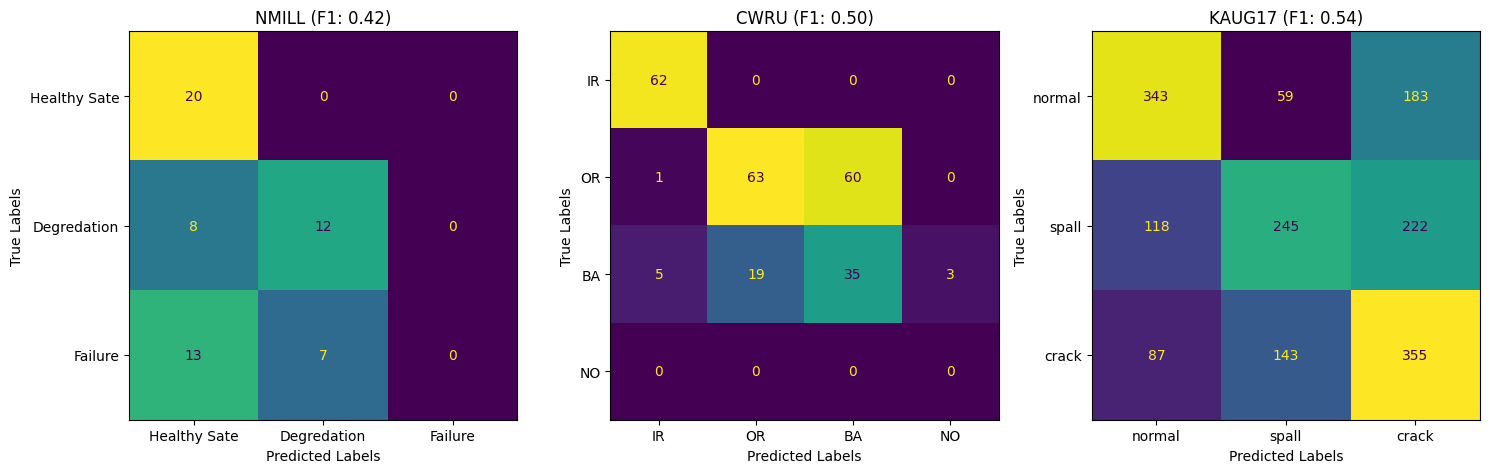

In [37]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over datasets and axes
for ax, dataset in zip(axes, DATASETS):
    # Extract true values, predictions, and target labels
    Y_aux, Y_pred, target_labels = predictions[dataset]
    
    # Convert probabilities to class predictions
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    
    # Calculate F1 Score
    f1 = f1_score(Y_aux, Y_pred_classes, average='macro')
    
    # Generate the confusion matrix
    cm = confusion_matrix(Y_aux, Y_pred_classes)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
    disp.plot(ax=ax, colorbar=False)
    
    # Add title and F1 score to the plot
    ax.set_title(f'{dataset} (F1: {f1:.2f})')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')


# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('diag_example.svg')
plt.show()
